In [1]:
from astropy import units as u
from astropy.time import Time, TimeDelta
import numpy as np

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.core.perturbations import J2_perturbation
from poliastro.core.propagation import func_twobody
from poliastro.twobody.propagation import CowellPropagator

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

size = 16
plt.rcParams.update({'font.size': size})

In [2]:
# Building the combined two‑body + J2 acceleration function
def j2_cowell(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    # compute J2 accel components
    ax, ay, az = J2_perturbation(
        t0,
        state,
        k,
        Earth.J2.value,
        Earth.R.to(u.km).value,
    )
    du_ad = np.array([0.0, 0.0, 0.0, ax, ay, az])
    # total derivative
    return du_kep + du_ad

In [3]:
# Cowell propagator
cowell_j2 = CowellPropagator(f=j2_cowell)

In [ ]:
def find_satellite(t, perturbed=False):
    """
    Returns satellite position and velocity at t seconds after epoch.

    Parameters
    ----------
    t           : Time in seconds since the initial epoch
    perturbed   : Whether to include Earth's J2 perturbation

    Returns
    -------
    r           : Satellite position in GCRS frame
    v           : Satellite velocity in GCRS frame
    """
    dt = TimeDelta(t * u.s)
    if perturbed:
        # J2‐perturbed propagation
        orb_t = orbit.propagate(dt, method=cowell_j2)
    else:
        # pure Keplerian propagation
        orb_t = orbit.propagate(dt)
        
    r, v = orb_t.rv()
    return r.to(u.km), v.to(u.km / u.s)

In [ ]:
# Defining all the altitudes considered
dL = 250.0
L = np.arange(5e5, 10e6 + dL, dL)

kep = {}    # Non-perurbed data
per = {}    # Perturbed data

for alt in L:
    orbit = Orbit.from_classical(
        Earth,                  # Attractor
        Earth.R + (alt*u.km),   # semi-major axis
        0 * u.one,              # eccentricity
        0 * u.deg,              # inclination
        0 * u.deg,              # RAAN
        0 * u.deg,              # argument of perigree
        0 * u.deg,              # true anomaly
        epoch=Time.now(),       # reference time
    )

    # Compute one orbital period and create time samples
    T_orbit = orbit.period.to(u.s).value
    t_vals = np.linspace(0, T_orbit, 200)

    kep[alt] = np.empty_like(t_vals)
    per[alt] = np.empty_like(t_vals)

    for i,t in enumerate(t_vals):
        dd1, _ = find_satellite(t, perturbed=False)
        dd2, _ = find_satellite(t, perturbed=True)
        kep[alt][i] = np.linalg.norm(dd1.value)
        per[alt][i] = np.linalg.norm(dd2.value)    

C:\Users\agflo\AppData\Local\Temp\ipykernel_26508\123558909.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


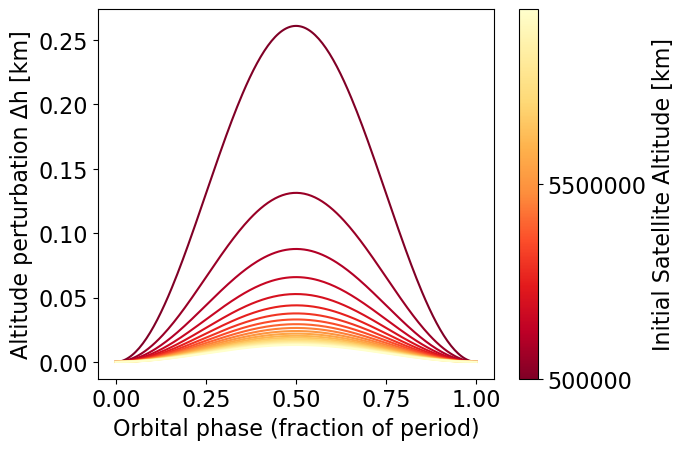

In [6]:
# Sorting all of the satellite altitudes
keys = sorted(kep.keys())
# Defining normalization
norm = Normalize(vmin=min(keys), vmax=max(keys))

# Making a yellow to red color map
cmap = cm.get_cmap('YlOrRd')

# Plotting all of our data
fig, ax = plt.subplots()
for key in keys:
    arr = kep[key] - per[key]
    x   = np.linspace(0, 1, len(arr))
    ax.plot(x, arr, color=cmap(1-norm(key)))

# Scaling everything
sm = ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
tick_locs = keys[::10]
cbar = fig.colorbar(sm, ax=ax, ticks=tick_locs)
cbar.set_label("Initial Satellite Altitude [km]")
cbar.ax.set_yticklabels([f"{k.astype(int)}" for k in tick_locs])

ax.set_xlabel("Orbital phase (fraction of period)")
ax.set_ylabel("Altitude perturbation Δh [km]")

# plt.savefig("../figures/delta-h.pdf", dpi=300, bbox_inches="tight")
plt.show()
